# Plain seq2seq model on synthetic data

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import numpy as np
import random

In [2]:
n_timesteps_in = 50 # length of input sequence
n_timesteps_out = 40 # length of output sequence

n_features_in = 1
n_features_out = 1

## Generate synthetic data

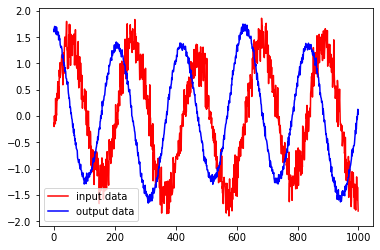

In [3]:
time_series_length = 1000
t = np.linspace(0, 10, time_series_length)
ts_input = np.sin(t) / 3 + 2 * np.sin(t*3) + 0.3 * np.random.standard_normal(size=time_series_length)
ts_output = np.cos(t) / 2 + 3 * np.cos(t*3) + 0.1 * np.random.standard_normal(size=time_series_length)
# normalize the data
ts_norm_input = (ts_input - np.mean(ts_input)) / np.std(ts_input)
ts_norm_output = (ts_output - np.mean(ts_output)) / np.std(ts_output)
plt.plot(ts_norm_input, 'r', label = 'input data')
plt.plot(ts_norm_output,'b', label = 'output data')

plt.legend()

In [4]:
train_size = int(len(ts_input) * 0.8)
test_size = len(ts_input) - train_size

train_input, test_input = ts_norm_input[0:train_size], ts_norm_input[train_size:len(ts_input)]
train_output, test_output = ts_norm_output[0:train_size], ts_norm_output[train_size:len(ts_input)]

## Generate dataset

In [5]:
seq_len = max(n_timesteps_in, n_timesteps_out)
def create_dataset():
    # train data
    train_input_data, train_output_data = [], []
    for i in range(500):
        rand_ind_train = random.randint(0, len(train_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_train:rand_ind_train+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_train:rand_ind_train+n_timesteps_out]
        train_input_data.append(input_seq)
        train_output_data.append(output_seq)
    # test data
    test_input_data, test_output_data = [], []   
    for i in range(5):
        rand_ind_test = random.randint(0, len(test_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_test:rand_ind_test+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_test:rand_ind_test+n_timesteps_out]
        test_input_data.append(input_seq)
        test_output_data.append(output_seq)
    return np.array(train_input_data), np.array(train_output_data), np.array(test_input_data), np.array(test_output_data)
        

In [6]:
train_input_data, train_output_data, test_input_data, test_output_data = create_dataset()

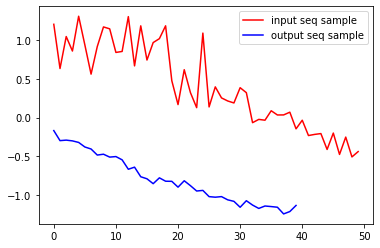

In [7]:
plt.plot(train_input_data[0], 'r', label = 'input seq sample')
plt.plot(train_output_data[0], 'b', label = 'output seq sample')
plt.legend()

## Build Model

In [8]:
# reshape input to be [n_samples, n_time_steps, n_features]
train_input_data = np.reshape(train_input_data, (train_input_data.shape[0], n_timesteps_in, n_features_in))
train_output_data = np.reshape(train_output_data, (train_input_data.shape[0], n_timesteps_out, n_features_out))

test_input_data = np.reshape(test_input_data, (test_input_data.shape[0], n_timesteps_in, n_features_in))
test_output_data = np.reshape(test_output_data, (test_input_data.shape[0], n_timesteps_out, n_features_out))

In [9]:
n_units = 128

encoder_inputs = keras.Input(shape=(n_timesteps_in, n_features_in))
encoder = keras.layers.LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

# Set up the decoder, using 'encoder_states' as initial state.
decoder_inputs = keras.Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  keras.layers.LSTM(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [10]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 40, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 66560       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 40, 128), (N 66560       input_2[0][0]                    
                                                                 lstm[0][1]                   

In [11]:
model.compile(optimizer='adam', loss='mse')

In [12]:
decoder_inputs = np.zeros(train_output_data.shape)

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

model.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=100, batch_size=64, validation_split=0.2, callbacks = my_callbacks, verbose=2)

Epoch 1/100
7/7 - 3s - loss: 0.8638 - val_loss: 0.7178
Epoch 2/100
7/7 - 0s - loss: 0.6266 - val_loss: 0.5853
Epoch 3/100
7/7 - 0s - loss: 0.5102 - val_loss: 0.4490
Epoch 4/100
7/7 - 0s - loss: 0.3803 - val_loss: 0.2075
Epoch 5/100
7/7 - 0s - loss: 0.2595 - val_loss: 0.1775
Epoch 6/100
7/7 - 0s - loss: 0.2017 - val_loss: 0.1595
Epoch 7/100
7/7 - 0s - loss: 0.1133 - val_loss: 0.0754
Epoch 8/100
7/7 - 0s - loss: 0.0808 - val_loss: 0.0601
Epoch 9/100
7/7 - 0s - loss: 0.0625 - val_loss: 0.0481
Epoch 10/100
7/7 - 0s - loss: 0.0473 - val_loss: 0.0436
Epoch 11/100
7/7 - 0s - loss: 0.0429 - val_loss: 0.0420
Epoch 12/100
7/7 - 0s - loss: 0.0371 - val_loss: 0.0348
Epoch 13/100
7/7 - 0s - loss: 0.0361 - val_loss: 0.0339
Epoch 14/100
7/7 - 0s - loss: 0.0311 - val_loss: 0.0303
Epoch 15/100
7/7 - 0s - loss: 0.0305 - val_loss: 0.0302
Epoch 16/100
7/7 - 0s - loss: 0.0378 - val_loss: 0.0516
Epoch 17/100
7/7 - 0s - loss: 0.0405 - val_loss: 0.0435
Epoch 18/100
7/7 - 0s - loss: 0.0423 - val_loss: 0.0390
E

## Results

In [13]:
decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model.predict([test_input_data, decoder_inputs])

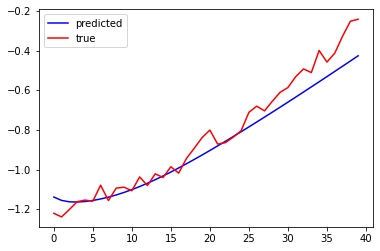

In [14]:
plt.plot(y_pred[0], 'b', label = 'predicted')
plt.plot(test_output_data[0], 'r', label = 'true')

plt.legend()